In [ ]:
import sys
sys.path.append("..")

In [ ]:
from inpainting.data.datasets import LlavaDataset
import torch
from transformers import AutoProcessor, LlavaNextForConditionalGeneration, BitsAndBytesConfig
from inpainting.models.metrics import CLIPScoreText2Image
from peft import PeftModel
from transformers import CLIPProcessor, CLIPTextModelWithProjection, CLIPVisionModelWithProjection
from torchmetrics.aggregation import MeanMetric
from pathlib import Path
import os
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import random
from torch.utils.data import DataLoader

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = LlavaDataset(
    data_dir="../data/mm_inp_dataset",
    max_concepts=5,
    generator=torch.Generator().manual_seed(42),
    remove_intersections=False,
    shuffle_concepts=True,
    masked_area_threshold=0.65,
    return_entity_PILs=True,
    only_gray_concept=False,
    override_gray=False,
    split="test"
)

In [ ]:
# sample 128 integers between 0 and 4999 without replacement
indices = random.sample(range(5000), 128)

In [ ]:
processor = AutoProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf")
processor.tokenizer.padding_side = "left"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf", torch_dtype=torch.float16, quantization_config=bnb_config)
model = PeftModel.from_pretrained(model, Path(os.getcwd()).parent / "models" / "llava" / "multimask" / "checkpoint-2884" / "adapter")

In [ ]:
clip_score = CLIPScoreText2Image(
    text_model=CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to(device),
    vision_model=CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to(device),
    processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32"),
).to(device)
self_bleu = MeanMetric()
dist_one = MeanMetric()

In [ ]:
num_beams=1
do_sample=True
temperature=2.0

In [ ]:
import numpy as np
import copy

def get_bleu_score(sentence, remaining_sentences):
    lst = []
    for i in remaining_sentences:
        bleu = sentence_bleu([sentence], i)
        lst.append(bleu)
    return lst


def calculate_selfBleu(sentences):
    '''
    sentences - list of sentences generated by NLG system
    '''
    bleu_scores = []
	
    for i in sentences:
        sentences_copy = copy.deepcopy(sentences)
        remaining_sentences = sentences_copy.remove(i)
        bleu = get_bleu_score(i,sentences_copy)
        bleu_scores.append(bleu)

    return np.mean(bleu_scores)

In [ ]:
from itertools import chain

def pad_sequence(sequence, n, pad_left=False, pad_right=False,
                 left_pad_symbol=None, right_pad_symbol=None):
    sequence = iter(sequence)
    if pad_left:
        sequence = chain((left_pad_symbol,) * (n - 1), sequence)
    if pad_right:
        sequence = chain(sequence, (right_pad_symbol,) * (n - 1))
    return sequence

def ngrams(sequence, n, pad_left=False, pad_right=False,
           left_pad_symbol=None, right_pad_symbol=None):
    sequence = pad_sequence(sequence, n, pad_left, pad_right,
                            left_pad_symbol, right_pad_symbol)

    history = []
    while n > 1:
        history.append(next(sequence))
        n -= 1
    for item in sequence:
        history.append(item)
        yield tuple(history)
        del history[0]

def distinct_n_sentence_level(sentence, n):
    """
    Compute distinct-N for a single sentence.
    :param sentence: a list of words.
    :param n: int, ngram.
    :return: float, the metric value.
    """
    if len(sentence) == 0:
        return 0.0  # Prevent a zero division
    distinct_ngrams = set(ngrams(sentence, n))
    return len(distinct_ngrams) / len(sentence)

In [ ]:
for idx in tqdm(indices):
    example = dataset[idx]
    color_predictions_group = []
    for i in range(4):
        masked_image = example["PIL_masked_images"]
        prompt = f"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nDiscover and describe the objects hidden behind the masks of the colors: {', '.join(example['entity_colors'])}. ASSISTANT:"
        inputs = processor(
            text=prompt,
            images=masked_image,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt",
        )
        output = model.generate(**inputs, max_new_tokens=512, stop_strings="</red>", tokenizer=processor.tokenizer, num_beams=num_beams, do_sample=do_sample, temperature=temperature)
        output = processor.decode(output[0], skip_special_tokens=True)
        keyword = "ASSISTANT: "
        keyword_idx = output.find(keyword)
        clean_prediction = (
            output[keyword_idx + len(keyword) :].strip().lower()
        )
        with open(f"predictions_{num_beams}_{do_sample}_{temperature}.txt", "a") as f:
            f.write(clean_prediction + "\n")

        color_predictions = []
        for color in example["entity_colors"]:
            if f"<{color}>" in clean_prediction and f"</{color}>" in clean_prediction:
                color_start = clean_prediction.find(f"<{color}>")
                color_end = clean_prediction.find(f"</{color}>")
                color_predictions.append(
                    clean_prediction[color_start + len(f"<{color}>") : color_end]
                )
            else:
                color_predictions.append("")
        color_predictions_group.append(color_predictions)
        clip_score.update(color_predictions, example["entity_PILs"])
        dist_1 = []
        for pred in color_predictions:
            dist_1.append(distinct_n_sentence_level(pred.split(), 1))
        dist_1 = np.mean(dist_1)
        dist_one.update(torch.tensor(dist_1))
    for j in range(len(color_predictions_group[0])):
        sentences = [color_predictions_group[i][j] for i in range(4)]
        self_bleu.update(torch.tensor(calculate_selfBleu(sentences)))

In [ ]:
clip_score.compute(), self_bleu.compute()

In [ ]:
dist_one.compute()

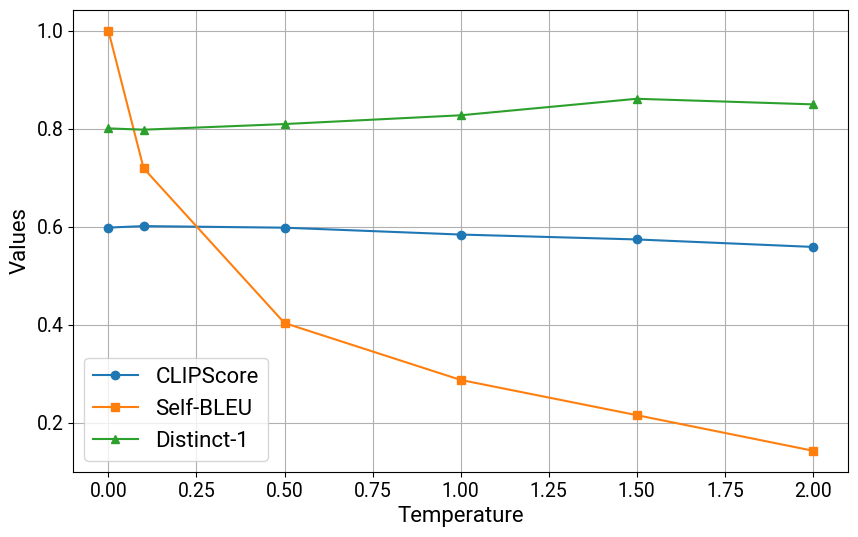

In [1]:
import matplotlib.pyplot as plt

from matplotlib import rcParams

# Set the font globally
rcParams["font.family"] = "Roboto"

# Optional: Set font for specific styles
rcParams["font.sans-serif"] = ["Roboto"]
rcParams["font.serif"] = ["Roboto"]

# Data
x = [0, 0.1, 0.5, 1.0, 1.5, 2.0]
f = [0.2393, 0.2405, 0.2392, 0.2336, 0.2296, 0.2235]
g = [1.0, 0.7193, 0.4034, 0.2873, 0.2154, 0.1428]
h = [0.8007, 0.7980, 0.8095, 0.8274, 0.8611, 0.8497]


# Normalization function
def normalize(data):
    min_val = min(data)
    max_val = max(data)
    return [(val - min_val) / (max_val - min_val) for val in data]


# Normalize the data
f_norm = [x * 2.5 for x in f]
g_norm = g
h_norm = h

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(x, f_norm, marker="o", label="CLIPScore")
plt.plot(x, g_norm, marker="s", label="Self-BLEU")
plt.plot(x, h_norm, marker="^", label="Distinct-1")

# Adding labels and title with larger font size
plt.xlabel("Temperature", fontsize=16)
plt.ylabel("Values", fontsize=16)

# Increase the size of tick labels on both axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Make the legend font larger using the 'prop' parameter
plt.legend(prop={"size": 16})
plt.grid(True)

# Save as SVG
plt.savefig("plot.svg", format="svg", bbox_inches="tight")